# Machine Learning Using White Shark Data

This notebook will use some supervised machine learning techniques in order to predict shark presence or absence in future datasets.

### General Housekeeping

In [1]:
# Import Libraries

# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

# Decision Trees
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree 

# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

# Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier

# K Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Gaussian Process
from sklearn.gaussian_process import GaussianProcessClassifier

# Grid Search
from sklearn.model_selection import GridSearchCV

In [2]:
# Build an easy function to get precision and recall
def precision_recall_calc(true, predicted):
    """"""" Calculates precision and recall scores for a particular model """""""
    cm = confusion_matrix(true, predicted)
    p = cm[0,0]/(cm[0,0] + cm[1,0])
    r = cm[0,0]/(cm[0,0] + cm[0,1])
    return p, r

### Data Aquisition and Formatting

In [3]:
# Read in the dataset and do some quick data cleanup.
dat = pd.read_csv('D:/Documents/SpringBoard/capstone-1/datasets/final_files/combined/'
                  'filled/jackknifed_counts.csv', 
                 parse_dates=['Date']) 

dat['Receiver_D'] = dat['Receiver_D'].astype('category') # turn receiver D into a category
    # for analyses and plotting
dat['Year'] = dat['Year'].astype('category') # turn into a category
dat['Transmitter'] = pd.to_numeric(dat['Transmitter'], errors='coerce') # and make
    # sure that the 'Transmitter' (shark density) is numeric
    
dat['Receiver_D'] = dat['Receiver_D'].cat.remove_unused_categories()

In [4]:
# Add presence v absence column
dat['presence'] = dat['Transmitter'].copy() # make a copy of the transmitter data
dat['presence'].values[dat['presence'].values > 1] = 1 # and convert transmitter vals > 1
    # to 1
dat['presence'] = dat['presence'].astype('category') # convert to category so
    # that we can run some t-tests
    
orig_dat = dat.copy() # to save in case we decide that we don't need to do dummies
    # to run a model (like is described in Decision Trees)

In [5]:
# Separate the data into predictors and response variables
response = dat.presence
dat = dat[['Zone', 'Receiver_D', 'DepthGradient', 'TempC', 'Sal', 'ChlA', 'MoonPhase', 'Month', 'Year']].copy()

In [6]:
# Get dummy variables and drop the original ones
zone = pd.get_dummies(dat.loc[:,'Zone']) # get dummies for zone
zone.columns = ['Zone_'+str(zone.columns[i]) for i in range(len(zone.columns))]
    # change column names so that they don't get confused with other values that may be
    # similar
dat[zone.columns[1:]] = zone.iloc[:,1:] # add the columns to dat and remove 1 to avoid
    # redundancy

lunar = pd.get_dummies(dat.loc[:,'MoonPhase']) # get dummies for lunar phase
dat[lunar.columns[1:]] = lunar.iloc[:,1:] # add columns and remove 1

month = pd.get_dummies(dat.loc[:,'Month']) # get dummies for month
month.columns = ['Month_'+str(month.columns[i]) for i in range(len(month.columns))]
    # change column names so they can't be confused with other factors
dat[month.columns[1:]] = month.iloc[:,1:] # add columns and remove 1

year = pd.get_dummies(dat.loc[:, 'Year']) # get dummies for year
year.columns = ['Year_'+str(year.columns[i]) for i in range(len(year.columns))]
    # change column names so they can't be confused with other factors
dat[year.columns[1:]] = year.iloc[:,1:] # add columns and remove 1

receivers = pd.get_dummies(dat.loc[:, 'Receiver_D']) # get dummies for receiver density
receivers.columns = ['ReceiverD_'+str(receivers.columns[i]) for i in range(len(receivers.columns))]
    # change column names so they can't be confused with other factors
dat[receivers.columns[1:]] = receivers.iloc[:,1:] # add columns and remove 1

# Clean up
dat = dat.drop(['Zone', 'MoonPhase', 'Month', 'Year', 'Receiver_D'], axis=1) 
    # drop the original columns now that we have the dummies set up

### Split into training and testing datasets

In [7]:
# Split data appropriately
X = dat
y = response

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33) 

### Method 1: Decision Trees

<b><i>Pros:</b></i> binary or multiclass classification, easy to interpret (with small max_depth), no normalization or dummy variables required, handles both numeric and classification variables, can validate models with statistical tests, performs well even if assumptions are violated

<b><i>Cons:</b></i> time consuming if the tree size is not controlled, the best tree may vary due to inherent randomness, overfitting is easy to do, results may be unstable and change based on small variations, figuring out the optimal number of trees requires random forests, and you must first balance the dataset to avoid biases.

In [8]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9861728395061728


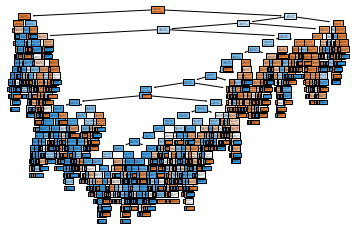

In [223]:
# Plot full decision tree to see what we're working with
tree.plot_tree(clf, filled=True) # build tree plot
plt.show() # show plot

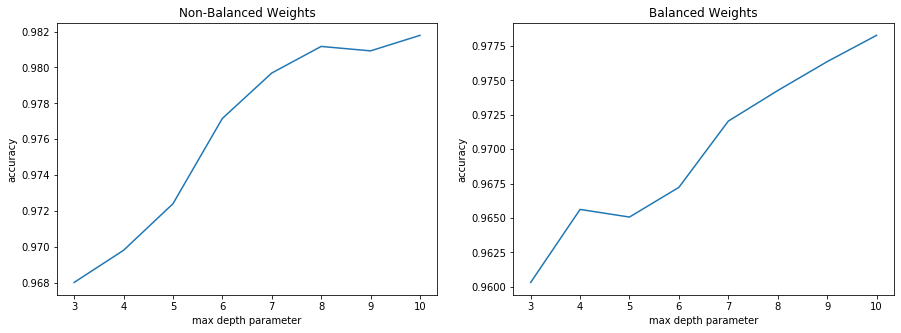

In [190]:
# Yikes. See which max depth (and balance level) comes up with the best accuracy

depths = range(3,11) # do a range between 3 and 11

accuracy_notbal = pd.DataFrame() # save accuracy for non-balanced data
accuracy_bal = pd.DataFrame() # save accuracy for balanced data

# Iterate through depths
for depth in depths: 
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=depth)
        # build model, switch criterion to entropy so that we can see how much more
        # information we get from each node

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)
    
    # Save the accuracy for the non-balanced model
    temp = pd.DataFrame({'max_depth':depth, 'accuracy': metrics.accuracy_score(y_test, y_pred)}, index=[0])
    accuracy_notbal = accuracy_notbal.append(temp, ignore_index=True)
    
    # Restart with balance parameter
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=depth, class_weight='balanced')
    
    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)
    
    # Save the results for the balanced model
    temp = pd.DataFrame({'max_depth':depth, 'accuracy': metrics.accuracy_score(y_test, y_pred)}, index=[0])
    accuracy_bal = accuracy_bal.append(temp, ignore_index=True)

# Plot the results next to each other
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5)) # initialize plot

# Plot the non-balanced model accuracy vs depth
ax1.plot(accuracy_notbal['max_depth'], accuracy_notbal['accuracy'])
ax1.set_xlabel('max depth parameter')
ax1.set_ylabel('accuracy')
ax1.set_title('Non-Balanced Weights')

# Plot the balanced model accuracy vs depth
ax2.plot(accuracy_bal['max_depth'], accuracy_bal['accuracy'])
ax2.set_xlabel('max depth parameter')
ax2.set_ylabel('accuracy')
ax2.set_title('Balanced Weights')

# Show the plot
plt.show()

It looks like these are two very different results. When the data aren't balanced, we don't really get a plateau in accuracy until a max depth of 7 or 8, which will be hard to interpret. With a balanced model, we see that the highest jump in accuracy is with a max depth of 3-4... which is easier to interpret. However, there really is no plateau in this instance.

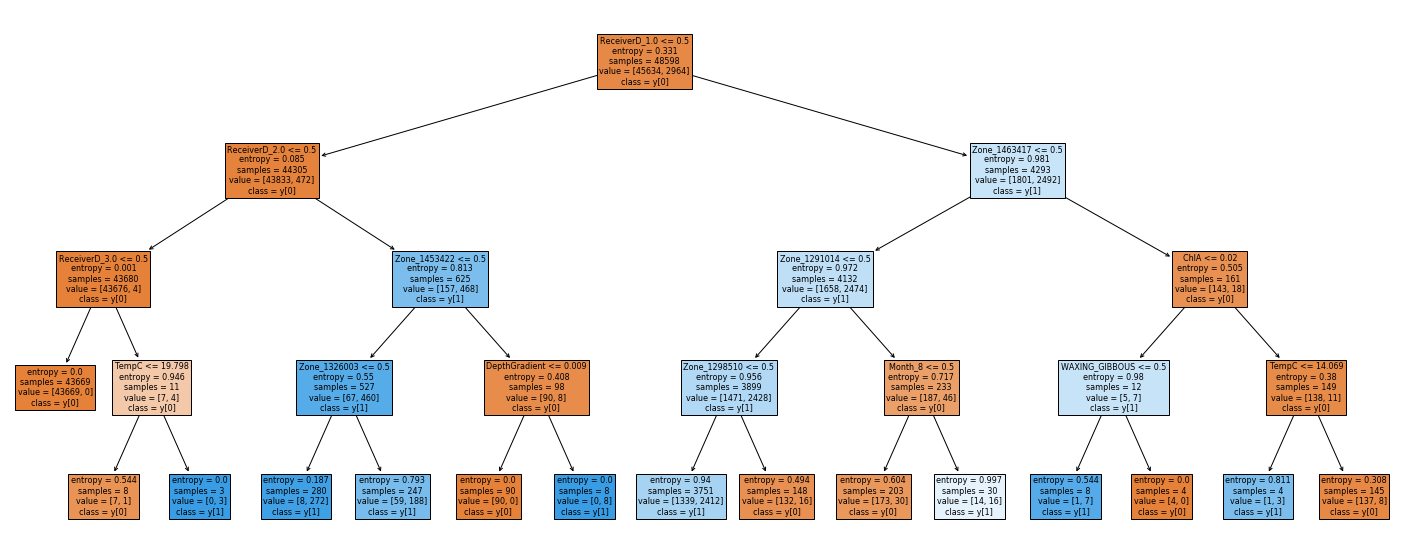

In [21]:
# Let's plot the decision tree for a balanced model with a max depth of 4
clf = DecisionTreeClassifier(criterion="entropy", max_depth=4)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
    
# Plot
plt.figure(figsize=(25,10))
tree.plot_tree(clf, filled=True, fontsize=8, class_names=True, feature_names=X.columns)  
plt.show()

This figure seems pretty easy to understand, but we're not entirely sure whether the parameters have been optimized. What's the best max depth? Should we balance the weights or not?

In [16]:
# Grid Search for tree classifier
parameters = {'max_depth':[3,4,5,6,7,8,9,10], 
             'class_weight': ('balanced', None)}
    # Set parameters
gs = DecisionTreeClassifier()
    # set classifier
clf = GridSearchCV(gs, parameters, cv=5)
    # run grid search with a fold of 5
clf.fit(X_train, y_train) # fit to the data
print(clf.best_params_) # give out the best parameters

{'class_weight': None, 'max_depth': 10}


In [18]:
# Fit the best parameters to the model
gs = DecisionTreeClassifier(max_depth=10)
gs.fit(X_train, y_train) # train
y_pred = gs.predict(X_test) # test
print(precision_recall_calc(y_test, y_pred)) # get the precision/recall

(0.995657112313757, 0.9854516598333554)


According to the grid search, it seems that the best model is when there are no class weights and when the max_depth is 10. When running a model with these parameters, it actually works pretty well. The precision is about 99.6% (most positive values are correct) and the recall is about 98.5% (there are few false negatives). Unfortunately, this makes the results very difficult to interpret (going through 10 levels to get to the answer). Therefore, perhaps decision trees are not the most appropriate model here. 

### Method 2: Gradient Boosting

<b><i>Pros:</b></i> useful for building more comprehensive models that learn from previous iterations, has a high performance

<b><i>Cons:</b></i> easy to overfit the data if you don't limit the number of trees or learning rate, not always easy to understand the output unless the max depth is limited, small variations can change the model output a lot

In [30]:
# Scale the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Do for a variety of learning rates
learning_rates = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

results = pd.DataFrame()
# Iterate through learnings rates
for learning_rate in learning_rates: # for each learning rate
    gb_clf = GradientBoostingClassifier(learning_rate=learning_rate, random_state=33)
        # run through the classifier
    gb_clf.fit(X_train, y_train) # fit to the training data

    y_test_pred = gb_clf.predict(X_test) # predict for the testing dataset
    
    # Save the result
    result = pd.DataFrame({'learning_rate': learning_rate, 'accuracy_train': gb_clf.score(X_train, y_train), 
                           'accuracy_test': gb_clf.score(X_test, y_test), 'precision_test': precision_recall_calc(y_test, y_test_pred)[0], 
                           'recall_test': precision_recall_calc(y_test, y_test_pred)[1]}, index=[0])
    
    # Add to results list
    results = results.append(result)

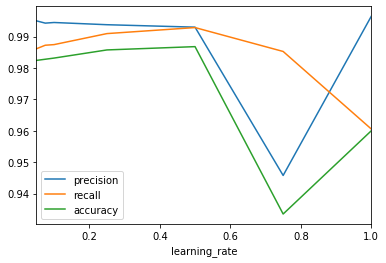

In [34]:
# Plot the resutls
results.plot('learning_rate', ['precision_test', 'recall_test', 'accuracy_test'])
    # plot all three
plt.legend(labels=['precision', 'recall', 'accuracy']) # fix legend labels
plt.show() # show plot

From this plot, it seems like there is a sweet spot at learning rate = 0.5, where the precision, regall, and accuracy are at their highest. Let's do a grid search to see if this is the case for other parameters like: seeing if we can minimize n_estimators (default = 100) or increase the max_depth (default = 3) for a better model fit.

In [213]:
# Grid Search for gradient boosting
parameters = {'learning_rate':[0.075, 0.1, 0.25, 0.5, 0.75], 'n_estimators':[10, 50, 100], 
             'max_depth':[3,6,8]}
    # Set parameters
gb = GradientBoostingClassifier()
    # set classifier
clf = GridSearchCV(gb, parameters, cv=5)
    # run grid search with a fold of 5
clf.fit(X_train, y_train) # fit to the data
print(clf.best_params_) # get the best parameters

{'learning_rate': 0.075, 'max_depth': 3, 'n_estimators': 100}

Above suggests that we should use a learning rate of 0.075 and keep the defaults for max_depth and n_estimators. GridSearchCV does an exhaustive search of all 5 potential folds of training data, so it's possible that we missed something in the original model search for values of learning rate that the GridSearch was able to pick up.

### Method 3: Stochastic Gradient Descent

<b><i>Pros:</b></i> efficient, easy to implement, can predict values, supports multiclass classification, supports weighted classes and instances

<b><i>Cons: </b></i> requires several hyperparameters, sensitive to future scaling, must shuffle data before fitting it (shuffle default set to True)

In [43]:
# Stochastic Gradient Descent
sgd = SGDClassifier()
    # set classifier with default parameters
sgd.fit(X_train, y_train) # fit to the data

y_pred = sgd.predict(X_test) # predict the results

print(precision_recall_calc(y_test, y_pred)) # get the precision and
    # recall scores

(0.99190605718835, 0.9886919719613808)


This model has pretty high precision and recall, but there might be a way to make it better by finding the best parameters for the best models. The best way to do this and be confident in the results is by using the grid search. 

In [ ]:
# Grid Search for SGDC
parameters = {'penalty':('l2', 'l1', 'elasticnet'), 
              'alpha':[0.0001, 0.001, 0.01],
              'l1_ratio': [0, 0.15, 0.5, 0.75, 1], 
              'max_iter':[100, 1000, 1500], 
              'learning_rate': ('constant', 'optimal', 'invscaling', 'adaptive'), 
              'power_t': [0.1, 0.5, 0.9], 
              'eta0': [0.075, 0.1, 0.25, 0.5, 0.75], 
              'class_weight': ('balanced', None)
             }
    # Set parameters
sgd = SGDClassifier()
    # set classifier
clf = GridSearchCV(sgd, parameters, cv=5)
    # run grid search with a fold of 5
clf.fit(X_train, y_train) # fit to the data
print(clf.best_params_) # get the best parameters

This method takes a very long time, and was running for over 12 hours without finishing. Therefore, doing a grid search for SGD does not seem to be a reasonable method for these data.

### Method 4: K Nearest Neighbors

<b><i>Pros:</b></i> simple, can weight neighbors based on distance

<b><i>Cons:</b></i> long testing time for large datasets

In [62]:
k_range = range(1,30) # set k range

scores = pd.DataFrame() # create dataset to save later
for k in k_range: # for each k
    knn = KNeighborsClassifier(n_neighbors=k) # plug it into the classifier
    knn.fit(X_train, y_train) # train the data
    y_test_pred = knn.predict(X_test) # test the data
    
    temp_df = pd.DataFrame({'k': k,'precision': precision_recall_calc(y_test, y_test_pred)[0] ,
                            'recall': precision_recall_calc(y_test, y_test_pred)[1]}, index=[0])
        # save the results
    scores = scores.append(temp_df)
        # add to running dataframe

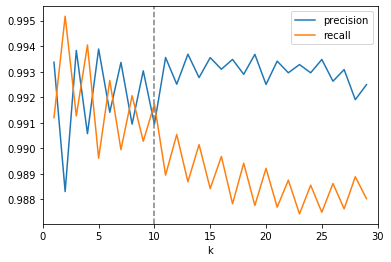

In [64]:
# Plot it
scores.plot('k', ['precision', 'recall'], legend=True) # plot both
plt.axvline(10, color='gray', linestyle='dashed') # where the highest two
    # values may lie
plt.xlim(0,30) # set limits
plt.show() # show plot

From this figure, it seems like a k value of 3 results in the most similar values (~0.99) in both precision and recall. Let's run this iteration again but with weights set on the distance between points to see if the results change.

In [50]:
k_range = range(1,30) # set k range

scores = pd.DataFrame() # create dataframe to add to
for k in k_range: # for each k
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
        # add the k into the classifier and specify weights
    knn.fit(X_train, y_train) # train the model
    y_test_pred = knn.predict(X_test) # test the model
    
    temp_df = pd.DataFrame({'k': k,'precision': precision_recall_calc(y_test, y_test_pred)[0] ,
                            'recall': precision_recall_calc(y_test, y_test_pred)[1]}, index=[0])
        # save the results
    scores = scores.append(temp_df)
        # add to created list

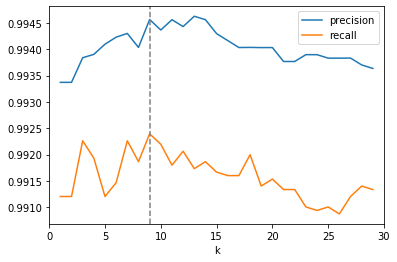

In [60]:
# Plot it
scores.plot('k', ['precision', 'recall'], legend=True) # plot both
plt.axvline(9, color='gray', linestyle='dashed') # where the highest two
    # values may lie
plt.xlim(0,30) # set limits
plt.show() # show plot

The loop to build the plots was running overnight, because it did not complete within three hours. Although time extensive, the precision and recall values were all above 0.99, which could not be said for the figure in which the points were not weighted by distance. It seems like this model is much more effective. It also appears that k values of 9 result in the highest values of both precision and recall, so this might be the k value for this particular model.

In [ ]:
# Grid Search for KNN
parameters = {'n_neighbors': [1,5,10,15,20,25,30] }
    # Set parameters
knn = KNeighborsClassifier()
    # set classifier
clf = GridSearchCV(knn, parameters, cv=5)
    # run grid search with a fold of 5
clf.fit(X_train, y_train) # fit to the data
print(clf.best_params_) # get the best parameters

This also takes a very long time to run (it was running for 5 hours before being terminated). Therefore, I think we can have a pretty good idea of which parameters to run for this model by using the precision/recall values indicated abaove.

### Method 4: Gaussian Naive Bayes

<b><i>Pros:</b></i> multiclass predictions, fast training and testing, easy to use, works well at high dimensions

<b><i>Cons:</b></i> values are assumed to be independent, requires lots of data for good estimates

In [53]:
# Gaussian Naive Bayes
gnb = GaussianNB() # build a gaussian classifier with no priors and 
    # a default smooth
gnb.fit(X_train, y_train) # fit the training data
y_pred = gnb.predict(X_test) # predict the test data
precision_recall_calc(y_test, y_pred) # and give me the accuracy/recall

(0.9998583770004249, 0.9337389234228277)

The precision is really good (99.99%) which means that most of the points that are identified as true by the model actually are true (not false positives). The recall isn't bad either (93.37%), meaning most of the points that are predicted are true positives and not false negatives. Since recall is less than precision, though, there are more instances of false negatives than false positives. This means that sometimes sharks were there but the model did not 'notice'.

### Method 5: Gaussian Process

<b><i>Pros:</b></i> can conduct a partial fit to speed up data processing and get better results, easy to implement, can interpolate positions, results are probabilistic, can use different kernels

<b><i>Cons:</b></i> lose efficiency in higher dimensions

In [ ]:
# Gaussian Process
gpc = GaussianProcessClassifier(copy_X_train=False) # build an empty classifier
gpc.fit(X_train, y_train) # fit the training data
y_pred = gpc.predict(X_test) # predict the test data
precision_recall_calc(y_test, y_pred) # give me accuracy and recall

When we run the cell above, we get a memory error. This is likely due to the high number of features that were introduced during building a one-hot encoding dataset. Google suggested adding copy_X_train=False to the model classifier to fix this problem, but it did not work here. Maybe we should try splitting the data into smaller groups and running the model, then taking the average of the results. 

In [138]:
splits = range(0, len(X_train), 5000) # split data into every 5000 points to train the classifier
gpc = GaussianProcessClassifier(copy_X_train=False) # build an empty classifier

for row, split in enumerate(splits):
    if split+5000 < len(X_train): 
        X_temp = X_train[split:split+5000,:]
        y_temp = y_train[split:split+5000]
    else: 
        X_temp = X_train[split:, :]
        y_temp = y_train[split:]
    gpc.fit(X_temp, y_temp) # fit the training data

y_pred = gpc.predict(X_test) # predict the test data
precision_recall_calc(y_test, y_pred) # give me accuracy and recall

(0.9532137896199016, 0.9983467795265176)

Compared to the other models run, the precision for the gaussian process classifier is lower (0.95 compared to 0.99 or 0.98). This means that the model is coming up with more false positives (thinks a shark is there when it actually isn't) than the other models. However, the recall values are similar to the other models, so the model is performing equally in regards to the number of true positives compared to false negatives.